In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from xgboost import XGBClassifier
import plotly.express as px

1- Visualisation globale :

In [189]:
# lecture du fichier csv
df = pd.read_csv("Dataset_Reponse_Marketing.csv")  

In [190]:
# Afficher toutes les lignes (par défaut : 10-60 selon env.)
pd.set_option('display.max_rows', None)

# Afficher toutes les colonnes (sinon il coupe avec ... aussi)
pd.set_option('display.max_columns', None)

# Éviter le raccourci dans les valeurs
pd.set_option('display.max_colwidth', None)

In [191]:
# Affichage des premières lignes
df.head()

,Age,Sexe,Revenu_annuel,Temps_passe_sur_site,Achats_en_ligne,Reponse_campagne
0,22,Homme,40124,16.518974,9,1
1,32,Femme,26307,21.973535,8,1
2,28,Femme,30040,26.762915,9,1
3,16,Femme,15843,29.046008,9,0
4,45,Homme,20225,21.479944,5,0


In [192]:
# Aperçu des informations du dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   2400 non-null   int64  
 1   Sexe                  2400 non-null   object 
 2   Revenu_annuel         2400 non-null   int64  
 3   Temps_passe_sur_site  2400 non-null   float64
 4   Achats_en_ligne       2400 non-null   int64  
 5   Reponse_campagne      2400 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 112.6+ KB


In [193]:
# Aperçu des informations du dataset
df.describe(include='all')

,Age,Sexe,Revenu_annuel,Temps_passe_sur_site,Achats_en_ligne,Reponse_campagne
count,2400.000000,2400,2400.000000,2400.000000,2400.000000,2400.000000
unique,NaN,2,NaN,NaN,NaN,NaN
top,NaN,Femme,NaN,NaN,NaN,NaN
freq,NaN,1238,NaN,NaN,NaN,NaN
mean,34.611250,NaN,26197.005000,22.073762,7.642083,0.526250
std,10.087287,NaN,7062.015627,3.993837,1.612471,0.499415
min,-1.000000,NaN,4422.000000,8.656394,2.000000,0.000000
25%,28.000000,NaN,21414.250000,19.381206,7.000000,0.000000
50%,35.000000,NaN,26222.000000,22.072839,8.000000,1.000000
75%,42.000000,NaN,30909.250000,24.798229,9.000000,1.000000


In [194]:
# Nombre total de données manquantes
df.isnull().sum().sum()

np.int64(0)

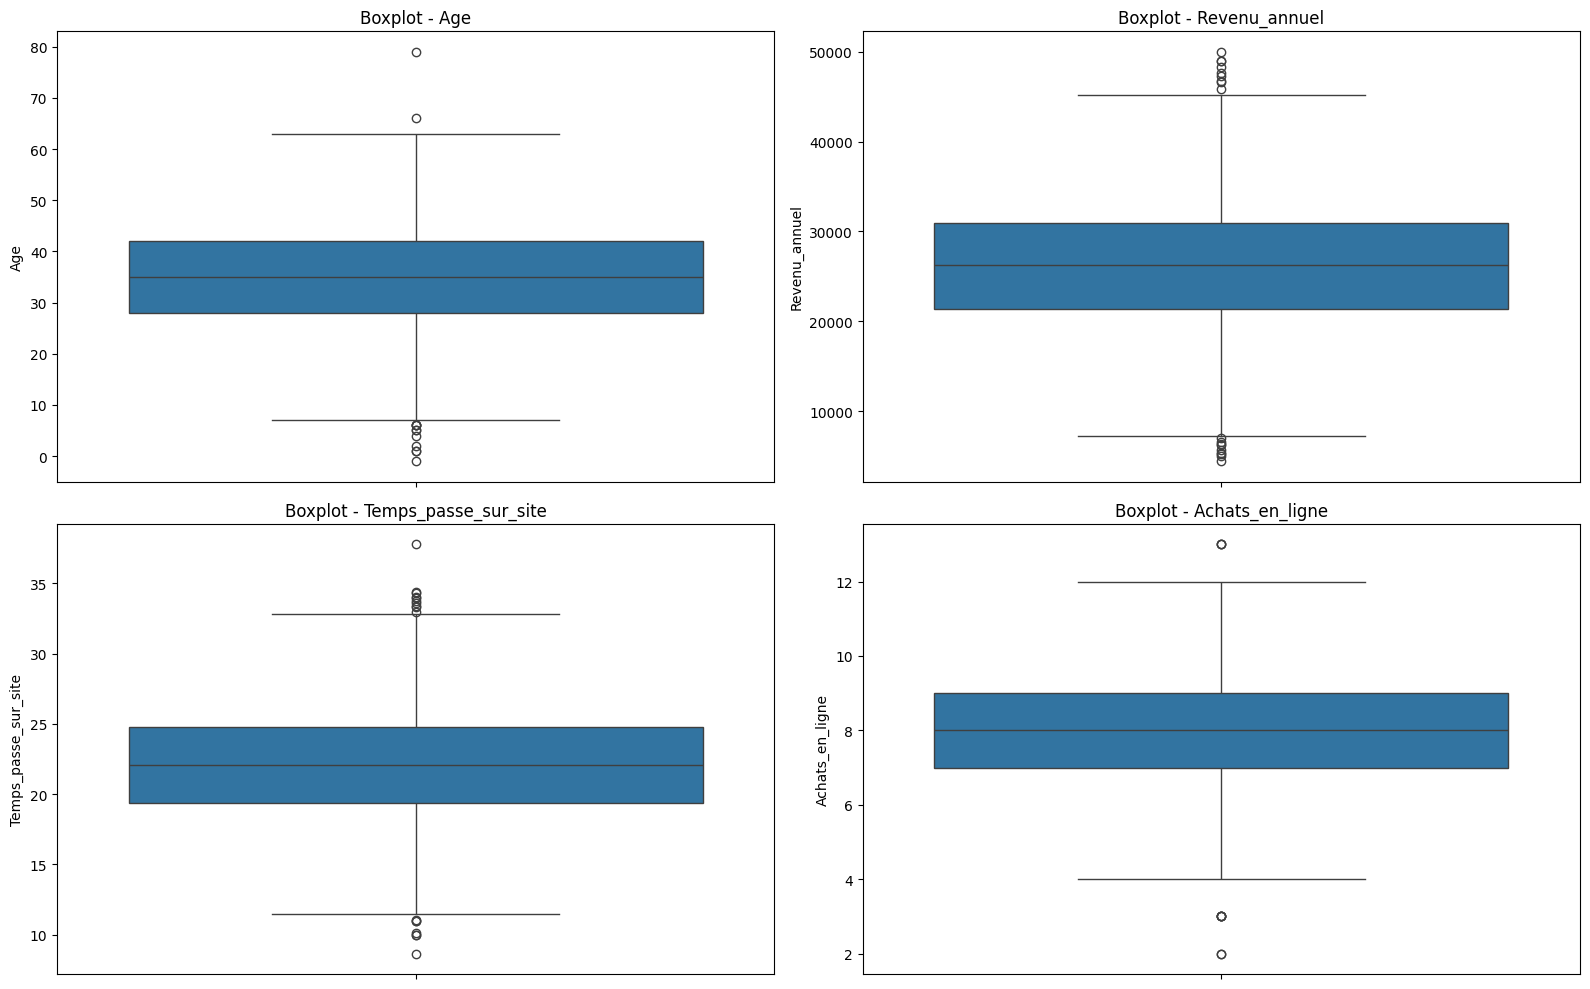

In [195]:
# Boxplots pour chaque variable numérique
plt.figure(figsize=(16, 10))
for i, col in enumerate(['Age', 'Revenu_annuel', 'Temps_passe_sur_site', 'Achats_en_ligne']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot - {col}")
plt.tight_layout()
plt.show()

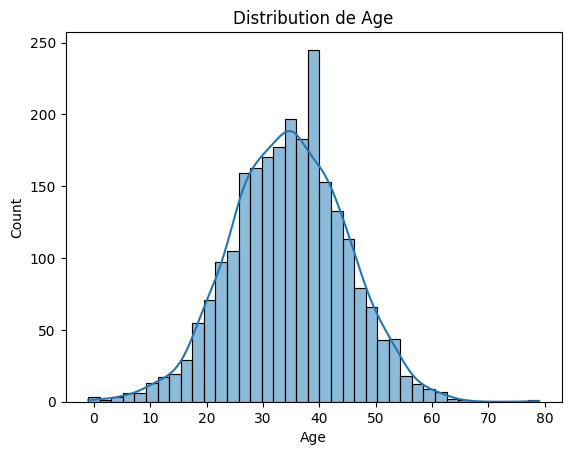

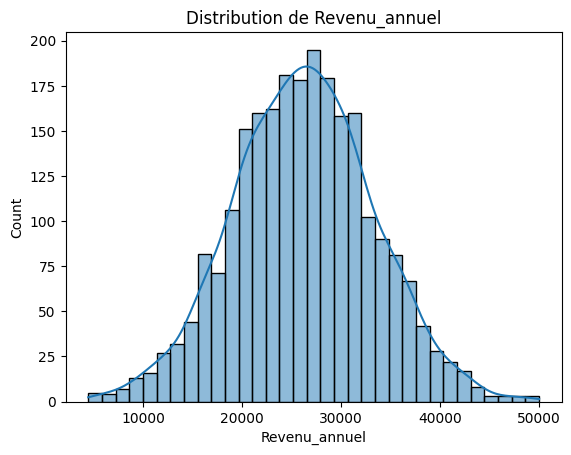

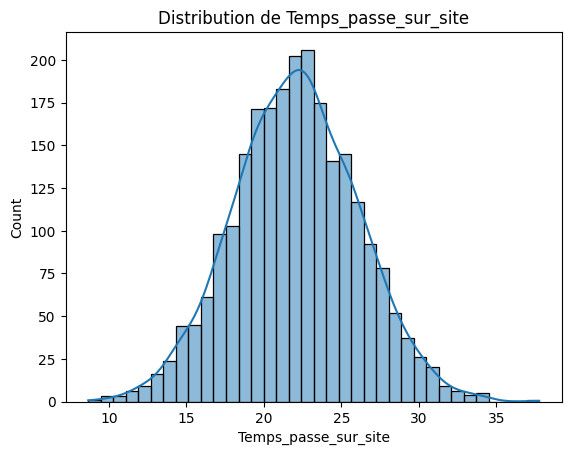

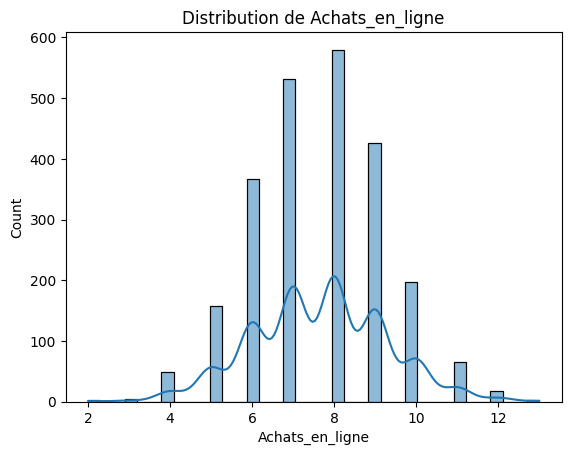

In [196]:
# Histogrammes
for col in ['Age', 'Revenu_annuel', 'Temps_passe_sur_site', 'Achats_en_ligne']:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()

📊 Répartition du sexe :
Sexe
Femme    1238
Homme    1162
Name: count, dtype: int64


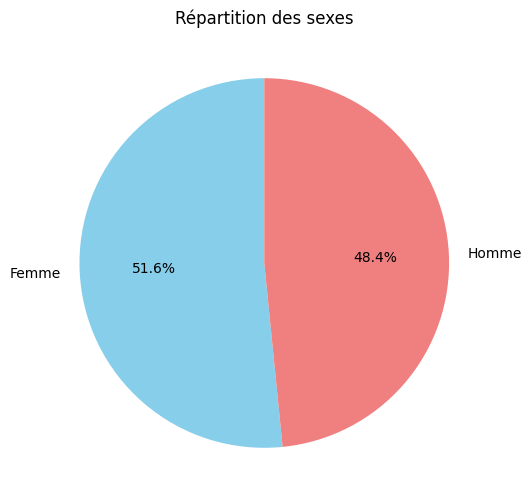

In [197]:
# Compter le nombre d'hommes et de femmes
repartition_sexe = df['Sexe'].value_counts()

# Affichage
print("📊 Répartition du sexe :")
print(repartition_sexe)

# Visualisation avec un camembert
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
repartition_sexe.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title("Répartition des sexes")
plt.ylabel('')  # Supprimer le label y
plt.show()

📊 Nombre de réponses à la campagne :
✅ A répondu : 1263
❌ N'a pas répondu : 1137


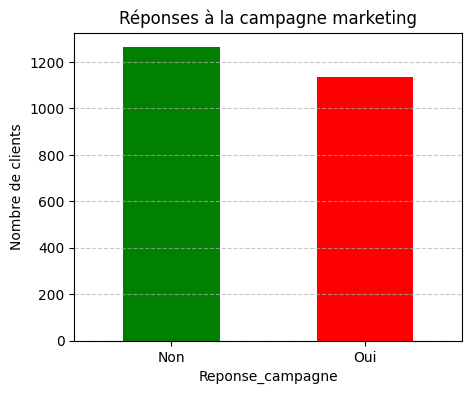

In [198]:
# Compter les réponses (1 = répondu, 0 = pas répondu)
reponse_campagne = df['Reponse_campagne'].value_counts()

# Affichage
print("📊 Nombre de réponses à la campagne :")
print(f"✅ A répondu : {reponse_campagne.get(1, 0)}")
print(f"❌ N'a pas répondu : {reponse_campagne.get(0, 0)}")

# Visualisation en barres
plt.figure(figsize=(5, 4))
reponse_campagne.plot(kind='bar', color=['green', 'red'])
plt.title("Réponses à la campagne marketing")
plt.xticks([0, 1], ['Non', 'Oui'], rotation=0)
plt.ylabel("Nombre de clients")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

2- Gestion des outliers et décisions : 

Pour rester cohérent avec le but d'un site d'e-commerce, je choisis de supprimer les données qui sont très petits et peuvent pas avoir un revenu ni acheter des produits en ligne sans aide et également les personnes trop agés.

Reste à faire des choix selon le nombre de données et l'incohérence.


In [199]:
print(df[(df['Age'] > 65)])


      Age   Sexe  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  \
568    66  Femme          23520             24.884647                7   
1499   79  Homme          28376             19.049495                8   

      Reponse_campagne  
568                  1  
1499                 0  


In [200]:
print(df[(df['Age'] < 16)])

      Age   Sexe  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  \
111    13  Homme          27676             24.669532                8   
145    15  Homme          11859             25.786194                8   
151    12  Homme          27597             25.194020                7   
225    15  Femme          26562             24.180564                7   
237     1  Homme          28120             22.971610                8   
260    13  Homme          36368             18.455549                8   
298    15  Homme          30543             20.874160                9   
308    11  Femme          42578             31.704342               12   
310     2  Femme          14211             24.493669                6   
351    15  Homme          34893             11.874280                5   
371     6  Homme          31272             19.580502                8   
386    11  Femme          19812             20.240587                6   
403    10  Femme          25684       

In [201]:
nombre_moins_16 = df[df['Age'] < 16].shape[0]
print(f"Nombre de personnes avec un âge < 16 ans : {nombre_moins_16}")

nombre_moins_14 = df[df['Age'] < 14].shape[0]
print(f"Nombre de personnes avec un âge < 14 ans : {nombre_moins_14}")

nombre_moins_12 = df[df['Age'] < 12].shape[0]
print(f"Nombre de personnes avec un âge < 12 ans : {nombre_moins_12}")

nombre_moins_10 = df[df['Age'] < 10].shape[0]
print(f"Nombre de personnes avec un âge < 10 ans : {nombre_moins_10}")

Nombre de personnes avec un âge < 16 ans : 68
Nombre de personnes avec un âge < 14 ans : 49
Nombre de personnes avec un âge < 12 ans : 32
Nombre de personnes avec un âge < 10 ans : 19


In [202]:
# Nombre total d'observations dans le dataset
nb_total = df.shape[0]

# Pourcentage
pourcentage_16 = (nombre_moins_16 / nb_total) * 100

# Affichage propre
print(f"📊 Il y a {nombre_moins_16} personnes sur {nb_total} (soit {pourcentage_16:.2f}%) ayant moins de 16 ans.")


📊 Il y a 68 personnes sur 2400 (soit 2.83%) ayant moins de 16 ans.


In [203]:
# Suppression des outliers dans la colonne Age (moins de 16 ans ou plus de 70 ans)
df_cleaned = df[(df['Age'] >= 16) & (df['Age'] <= 70)].copy()

# Vérification : combien de lignes restantes ?
print(f"Nombre de lignes après suppression : {df_cleaned.shape[0]} (sur {nb_total} initiales)")


Nombre de lignes après suppression : 2331 (sur 2400 initiales)


3- Gestion des variables catégorielles

Puisque la colonne Sexe est de type binaire du coup on encode avec label encoder en donnant 0 pour Femme et 1 pour Homme selon l'ordre alphabétique.



In [204]:
# Encodage de la variable Sexe
le = LabelEncoder()
df_cleaned['Sexe'] = le.fit_transform(df_cleaned['Sexe'])

In [205]:
df_cleaned.head()

,Age,Sexe,Revenu_annuel,Temps_passe_sur_site,Achats_en_ligne,Reponse_campagne
0,22,1,40124,16.518974,9,1
1,32,0,26307,21.973535,8,1
2,28,0,30040,26.762915,9,1
3,16,0,15843,29.046008,9,0
4,45,1,20225,21.479944,5,0


4- coorélation des données


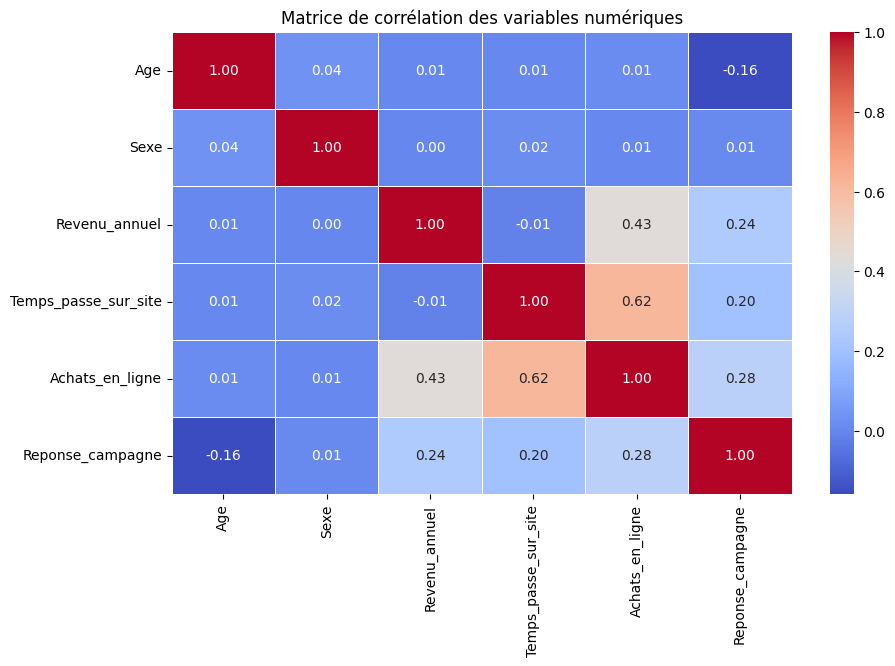

In [206]:
# Calcul et affichage de la matrice de corrélation
correlation_matrix = df_cleaned.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

5- Normalisation des données et séparation  : 

In [207]:
problem = df_cleaned.drop("Reponse_campagne", axis=1)
solution = df_cleaned["Reponse_campagne"]

In [208]:
# Normalisation


numerical_features = ['Age', 'Revenu_annuel', 'Temps_passe_sur_site', 'Achats_en_ligne']
categorical_features = ['Sexe']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(problem[numerical_features])


In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, solution, random_state=18)

6-PCA

La colonne "Sexe" est une variable catégorielle, même si elle a été encodée en 0/1, ce n’est pas une variable numérique continue, et donc elle ne doit pas être traitée comme telle dans une analyse de variance comme la PCA.


On utilise la PCA ici que pour un interet de visualisation car on n'a ni beaucoup de données ni une forte coorélation.

In [210]:
pca_object = PCA()
principal_component_problem = pca_object.fit_transform(X_scaled)
explained_variance = pca_object.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

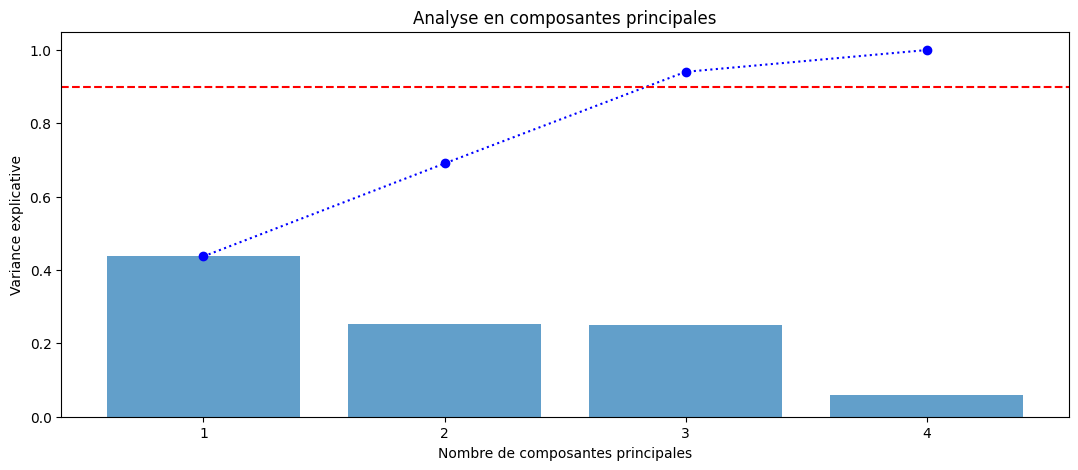

In [211]:
plt.figure(figsize=(13, 5))
plt.xticks(ticks=range(1, 5))
plt.bar(range(1,len(cumulative_variance) + 1), explained_variance,alpha=0.7,label='explained_variance')
plt.plot(range(1,len(cumulative_variance) + 1), cumulative_variance, "bo:", label='cumulative_variance')
plt.axhline(y=0.9, color="red", linestyle="--", label="90 % d'information utile")
plt.title("Analyse en composantes principales")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance explicative")
plt.show()

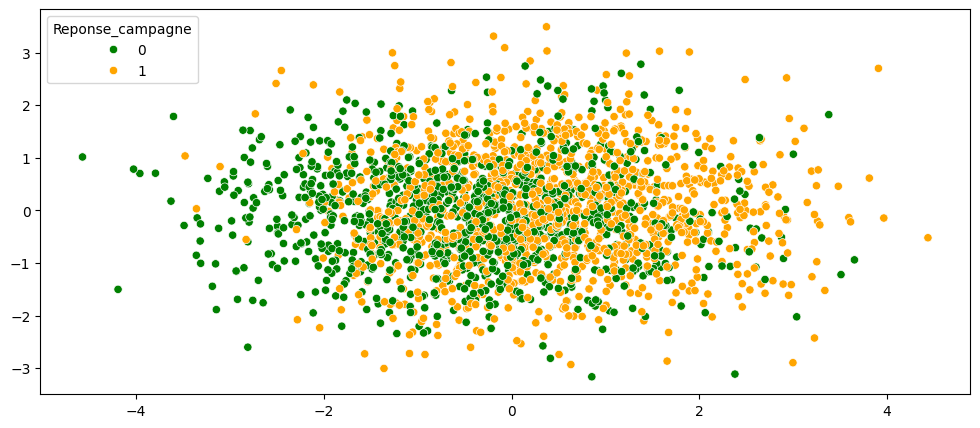

In [212]:
plt.figure(figsize=(12,5))
custom_palette = {0 : "green", 1:"orange"}
sns.scatterplot(x=principal_component_problem[:, 0], y=principal_component_problem[:,1], hue=solution, palette=custom_palette)
plt.show()

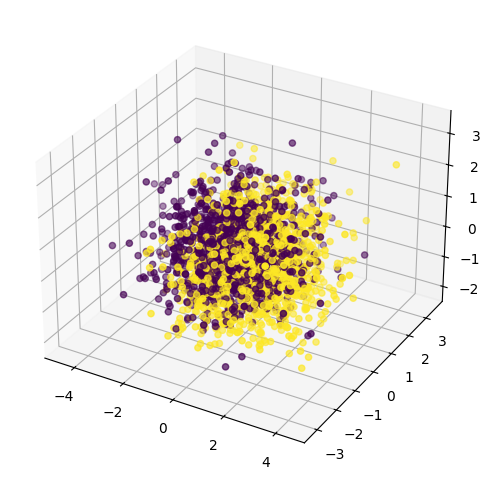

In [213]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(projection="3d")
ax.scatter(principal_component_problem[:, 0], principal_component_problem[:, 1], principal_component_problem[:, 2], c=solution)
plt.show()

7- Modélisation : Régression Logistique (sans et avec pca)

In [214]:
# Création du modèle
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = log_model.predict(X_test)

In [215]:
# Évaluation des performances
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Évaluation de la Régression Logistique :")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred))

Évaluation de la Régression Logistique :
Accuracy  : 0.626
Precision : 0.629
Recall    : 0.691
F1-score  : 0.658

Classification Report :

              precision    recall  f1-score   support

           0       0.62      0.56      0.59       279
           1       0.63      0.69      0.66       304

    accuracy                           0.63       583
   macro avg       0.63      0.62      0.62       583
weighted avg       0.63      0.63      0.62       583



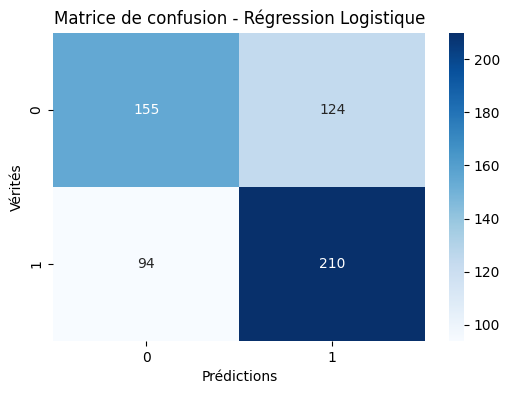

In [216]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - Régression Logistique")
plt.show()

Évaluation de la Régression Logistique après PCA :
Accuracy  : 0.608
Precision : 0.623
Recall    : 0.665
F1-score  : 0.643

Classification Report :

              precision    recall  f1-score   support

           0       0.59      0.54      0.57       219
           1       0.62      0.67      0.64       248

    accuracy                           0.61       467
   macro avg       0.61      0.60      0.60       467
weighted avg       0.61      0.61      0.61       467



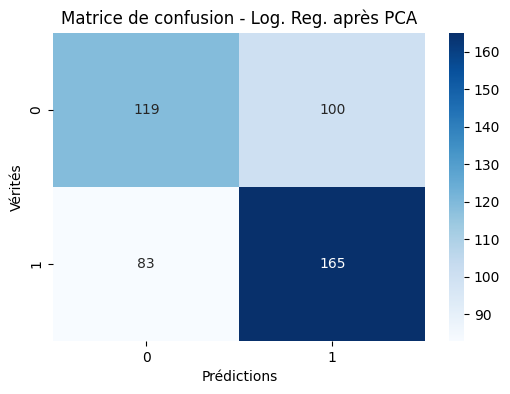

In [217]:
# Comparaison avec pca en prenant les 3 premières composantes principales
X_pca = principal_component_problem[:, :3]

# Séparation train/test dans l'espace réduit
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, solution, test_size=0.2, random_state=18)

# Création et entraînement du modèle
log_model_pca = LogisticRegression()
log_model_pca.fit(X_train_pca, y_train_pca)

# Prédictions
y_pred_pca = log_model_pca.predict(X_test_pca)

# Évaluation
accuracy = accuracy_score(y_test_pca, y_pred_pca)
precision = precision_score(y_test_pca, y_pred_pca)
recall = recall_score(y_test_pca, y_pred_pca)
f1 = f1_score(y_test_pca, y_pred_pca)

print("Évaluation de la Régression Logistique après PCA :")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("\nClassification Report :\n")
print(classification_report(y_test_pca, y_pred_pca))

# Matrice de confusion
cm = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - Log. Reg. après PCA")
plt.show()

8- Modélisation KNN : ( comme vu en cours)

In [218]:
#GridSearchCV pour trouver le meilleur k

# Recherche du meilleur k avec validation croisée (f1_macro)
def get_optimal_k_value(X_scaled, solution):
    parameters = {"n_neighbors": np.arange(1, 52, 2)}
    grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring="f1_macro")
    grid_search.fit(X_scaled, solution)
    
    print("Meilleur k trouvé :", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    scores = pd.DataFrame(grid_search.cv_results_)
    
    return best_model, scores

# Lancer la recherche du meilleur k
best_knn_model, knn_scores = get_optimal_k_value(X_scaled, solution)

Meilleur k trouvé : {'n_neighbors': np.int64(51)}


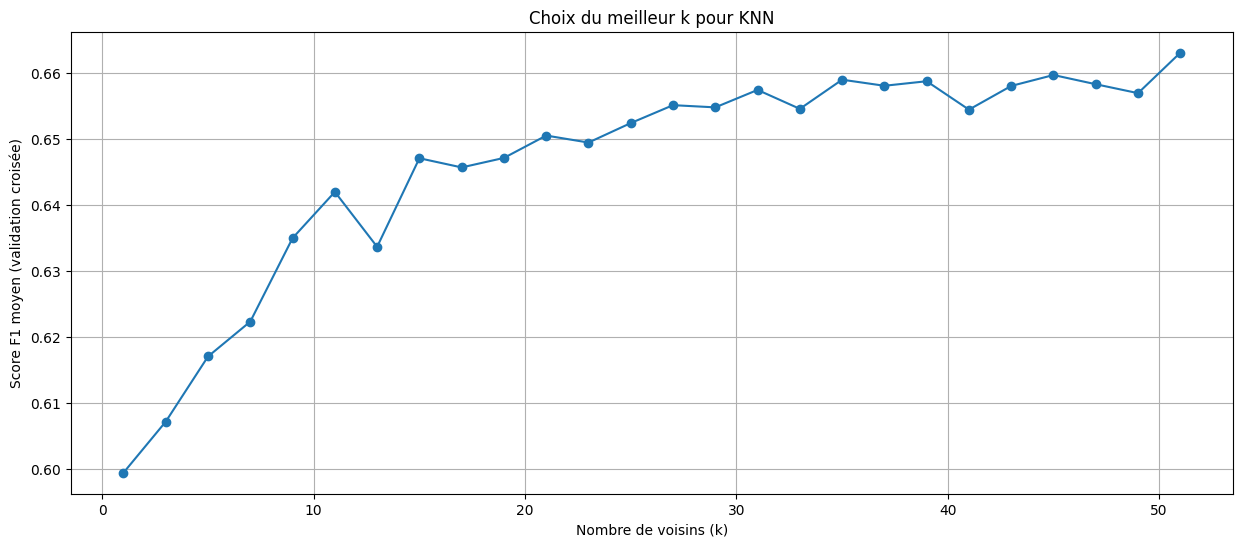

In [219]:
# Affichage du score moyen selon k

plt.figure(figsize=(15, 6))
plt.plot(knn_scores["param_n_neighbors"], knn_scores["mean_test_score"], marker='o')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Score F1 moyen (validation croisée)")
plt.title("Choix du meilleur k pour KNN")
plt.grid(True)
plt.show()


In [220]:
# Entraînement et analyse des voisins pour un point de test

# Ré-entraînement du meilleur KNN trouvé sur X_train
knn = KNeighborsClassifier(n_neighbors=best_knn_model.n_neighbors)
knn.fit(X_train, y_train)

# Afficher les voisins les plus proches d'un exemple de test
test_index = 199  # tu peux changer ce chiffre pour tester d'autres points
distances, indices = knn.kneighbors([X_test[test_index]])

print("Distances aux voisins :")
print(distances[0])

print("Indices des voisins :")
print(indices[0])

print("Labels des voisins :")
for idx in indices[0]:
    print(f"Index {idx} -> Classe : {y_train.iloc[idx]}")


Distances aux voisins :
[0.18431668 0.24412111 0.27671295 0.34189797 0.38162384 0.38980493
 0.39936183 0.4262265  0.44220301 0.45168446 0.49231109 0.53394533
 0.53510422 0.53606822 0.56972166 0.62333787 0.63698225 0.64245332
 0.65838349 0.68868463 0.69291975 0.70069751 0.70070725 0.70202594
 0.71201682 0.71876169 0.72252342 0.73031708 0.73266658 0.73781877
 0.73856696 0.7397842  0.74205079 0.74894546 0.76308053 0.76420346
 0.76536083 0.76721332 0.76997136 0.77090172 0.77270735 0.77511465
 0.78116583 0.78455656 0.78574353 0.78645549 0.7928352  0.7990344
 0.80263866 0.80281579 0.80375889]
Indices des voisins :
[ 808 1219 1678  432 1004 1044  221  467  108 1351  958  163  425 1147
  401  731  854  338 1078  661  982 1155 1519  399  196  764   50  724
  655   90 1237  389 1643 1256  136 1651 1020  778 1109  250  195  503
  813   48  863  554 1005  315 1581  841  488]
Labels des voisins :
Index 808 -> Classe : 1
Index 1219 -> Classe : 0
Index 1678 -> Classe : 1
Index 432 -> Classe : 0
Index

Évaluation du KNN :
              precision    recall  f1-score   support

           0       0.65      0.57      0.61       279
           1       0.65      0.71      0.68       304

    accuracy                           0.65       583
   macro avg       0.65      0.64      0.64       583
weighted avg       0.65      0.65      0.64       583



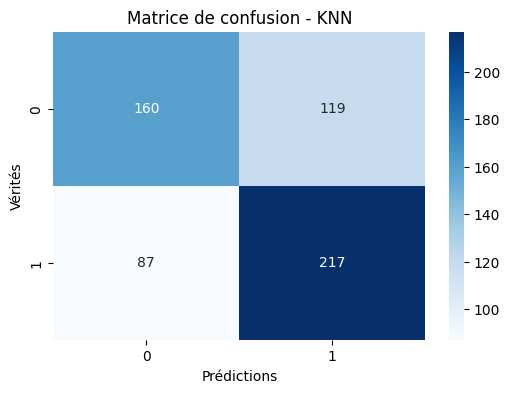

In [221]:
# Évaluation du modèle KNN sur l’ensemble X_test

from sklearn.metrics import classification_report, confusion_matrix

# Prédictions
y_pred_knn = knn.predict(X_test)

# Évaluation
print("Évaluation du KNN :")
print(classification_report(y_test, y_pred_knn))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - KNN")
plt.show()


### 🧠 Analyse du modèle KNN

- Le `GridSearchCV` a permis de déterminer que le meilleur nombre de voisins `k` est **51**, avec un **score F1 macro optimal**.
- La **courbe des scores** montre que les performances se stabilisent autour de ce `k`.
- En analysant un exemple de test, on observe que la **majorité de ses voisins** appartiennent à la classe prédite, ce qui confirme la logique de décision du modèle.
- Le modèle a obtenu des **scores intéressants** (accuracy, recall, precision, F1) mais reste légèrement en retrait par rapport à la régression logistique dans notre cas.

### ✅ Avantages :
- Facile à comprendre et à implémenter.
- Ne nécessite pas d’apprentissage réel (lazy learner).
- Donne des résultats raisonnables quand les classes sont bien séparées.

### ⚠️ Limites :
- Sensible à la normalisation (d’où l’importance de la `StandardScaler`).
- Performances qui chutent si les données sont trop dispersées ou bruitées.
- Coûteux en calcul si le jeu de données est très grand.

### 🎯 Conclusion :
- KNN est un bon point de comparaison.
- Dans notre cas, la **régression logistique semble plus robuste**, mais KNN reste utile à interpréter visuellement.


9- Modélisation arbre de décision : 

🌳 Évaluation du modèle Arbre de Décision :
Accuracy  : 0.617
Precision : 0.635
Recall    : 0.625
F1-score  : 0.630

Classification Report :

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       279
           1       0.64      0.62      0.63       304

    accuracy                           0.62       583
   macro avg       0.62      0.62      0.62       583
weighted avg       0.62      0.62      0.62       583



c:\EXERCICES\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


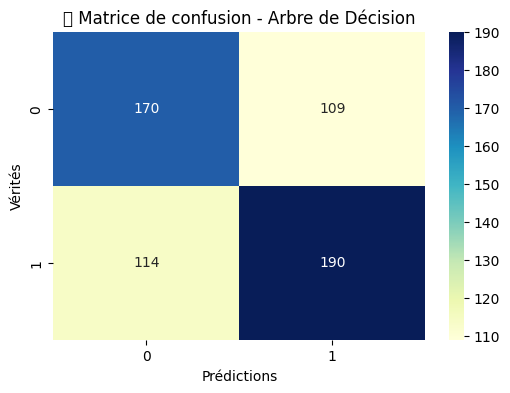

In [222]:
# Création du modèle sans réglage spécifique (on en fera plus avec GridSearch plus tard)
tree_model = DecisionTreeClassifier(random_state=18)
tree_model.fit(X_train, y_train)

# Prédictions
y_pred_tree = tree_model.predict(X_test)

# Évaluation des performances
accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)

print("🌳 Évaluation du modèle Arbre de Décision :")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred_tree))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("🌳 Matrice de confusion - Arbre de Décision")
plt.show()


In [223]:
# Définition de la grille d’hyperparamètres
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Création du modèle de base
tree = DecisionTreeClassifier(random_state=18)

# Création de la recherche par grille
grid_search_tree = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1  # utilise tous les cœurs disponibles
)

# Exécution du GridSearch
grid_search_tree.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
print("🌟 Meilleurs paramètres trouvés :")
print(grid_search_tree.best_params_)

# Utiliser le meilleur modèle trouvé
best_tree_model = grid_search_tree.best_estimator_


🌟 Meilleurs paramètres trouvés :
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


📈 Évaluation du meilleur Arbre de Décision (optimisé) :
Accuracy  : 0.662
Precision : 0.689
Recall    : 0.641
F1-score  : 0.664

Classification Report :

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       279
           1       0.69      0.64      0.66       304

    accuracy                           0.66       583
   macro avg       0.66      0.66      0.66       583
weighted avg       0.66      0.66      0.66       583



c:\EXERCICES\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


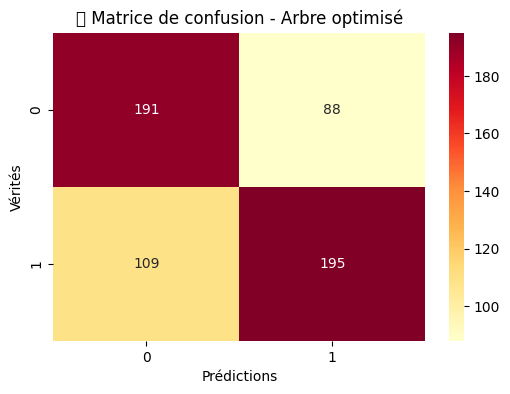

In [224]:
# Prédictions avec le meilleur modèle
y_pred_best_tree = best_tree_model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred_best_tree)
precision = precision_score(y_test, y_pred_best_tree)
recall = recall_score(y_test, y_pred_best_tree)
f1 = f1_score(y_test, y_pred_best_tree)

print("📈 Évaluation du meilleur Arbre de Décision (optimisé) :")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred_best_tree))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlOrRd", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("🌟 Matrice de confusion - Arbre optimisé")
plt.show()


10- Modélisation randomforrest : 

🌲 Évaluation du modèle Random Forest :
Accuracy  : 0.655
Precision : 0.665
Recall    : 0.684
F1-score  : 0.674

Classification Report :

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       279
           1       0.66      0.68      0.67       304

    accuracy                           0.66       583
   macro avg       0.65      0.65      0.65       583
weighted avg       0.65      0.66      0.65       583



c:\EXERCICES\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


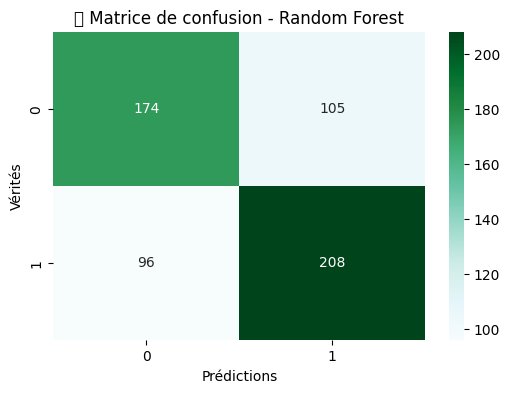

In [225]:
# Création et entraînement du modèle
rf_model = RandomForestClassifier(random_state=18)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print("🌲 Évaluation du modèle Random Forest :")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred_rf))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="BuGn", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("🌲 Matrice de confusion - Random Forest")
plt.show()


In [226]:

# Définir la grille d'hyperparamètres
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Créer le modèle de base
rf = RandomForestClassifier(random_state=18)

# Création du GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search_rf.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
print("🌟 Meilleurs paramètres Random Forest :")
print(grid_search_rf.best_params_)

# Récupérer le meilleur modèle
best_rf_model = grid_search_rf.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits
🌟 Meilleurs paramètres Random Forest :
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


📈 Évaluation du meilleur modèle Random Forest :
Accuracy  : 0.662
Precision : 0.671
Recall    : 0.691
F1-score  : 0.681

Classification Report :

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       279
           1       0.67      0.69      0.68       304

    accuracy                           0.66       583
   macro avg       0.66      0.66      0.66       583
weighted avg       0.66      0.66      0.66       583



c:\EXERCICES\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


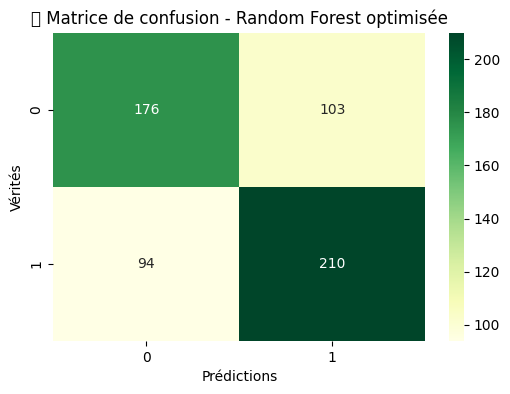

In [227]:
# Prédictions
y_pred_best_rf = best_rf_model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred_best_rf)
precision = precision_score(y_test, y_pred_best_rf)
recall = recall_score(y_test, y_pred_best_rf)
f1 = f1_score(y_test, y_pred_best_rf)

print("📈 Évaluation du meilleur modèle Random Forest :")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred_best_rf))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGn", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("🌟 Matrice de confusion - Random Forest optimisée")
plt.show()


11- Modélisation Xgboost :

🚀 Évaluation du modèle XGBoost :
Accuracy  : 0.645
Precision : 0.657
Recall    : 0.668
F1-score  : 0.662

Classification Report :

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       279
           1       0.66      0.67      0.66       304

    accuracy                           0.64       583
   macro avg       0.64      0.64      0.64       583
weighted avg       0.64      0.64      0.64       583



c:\EXERCICES\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\EXERCICES\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


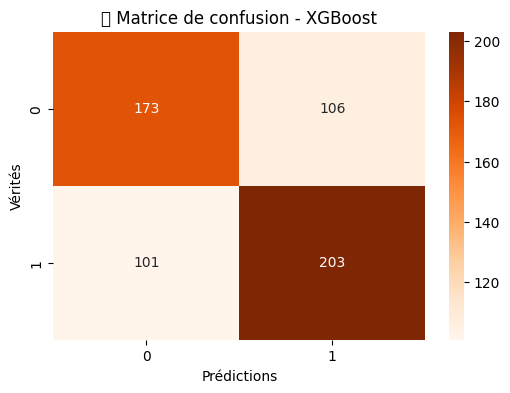

In [228]:
# Création du modèle XGBoost de base
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=18)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print("🚀 Évaluation du modèle XGBoost :")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred_xgb))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("🚀 Matrice de confusion - XGBoost")
plt.show()


12- comparaison des modèles : 

Même si le jeu de données n’est pas fortement déséquilibré (52.6% de non-réponses contre 47.4% de réponses), nous avons utilisé le F1-score pour évaluer les performances des modèles. Cela permet de prendre en compte à la fois la précision et le rappel, deux métriques importantes pour un projet de prédiction de réponse marketing.


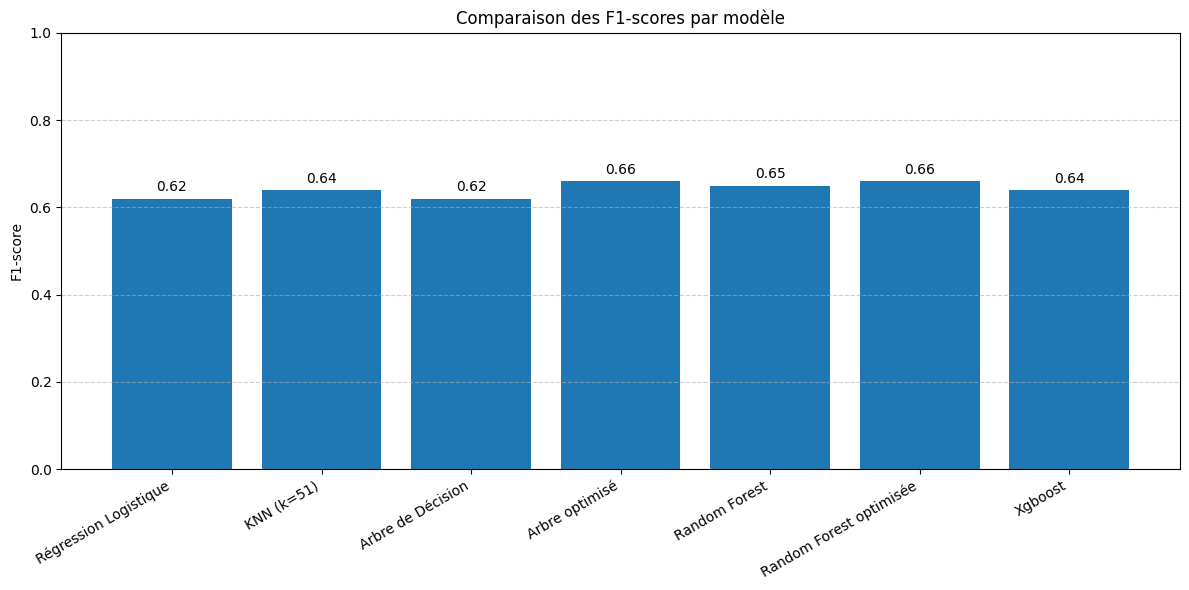

In [229]:
# Remplace ces valeurs par tes vrais résultats du notebook
models = [
    "Régression Logistique",
    "KNN (k=51)",
    "Arbre de Décision",
    "Arbre optimisé",
    "Random Forest",
    "Random Forest optimisée",
    "Xgboost"
]

f1_scores = [
    0.62,  
    0.64,  
    0.62,  
    0.66,  
    0.65,  
    0.66,
    0.64  
]

plt.figure(figsize=(12, 6))
bars = plt.bar(models, f1_scores)
plt.title("Comparaison des F1-scores par modèle")
plt.ylabel("F1-score")
plt.ylim(0, 1)

# Ajouter les scores sur les barres
for bar, score in zip(bars, f1_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{score:.2f}", ha='center', va='bottom')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### 🧠 Conclusion et analyse critique

Nous avons comparé plusieurs modèles de classification afin de prédire la réponse à une campagne marketing. Les performances ont été évaluées à l'aide du **F1-score macro** pour tenir compte de l'équilibre entre les deux classes.

#### 📊 Synthèse des résultats :
- Le modèle **d'Arbre de Décision optimisé** et la **Random Forest optimisée** ont obtenu les meilleurs résultats avec un **F1-score de 0.66**.
- Le modèle **XGBoost**, malgré sa réputation, n'a pas surpassé ces deux modèles dans ce cas précis.
- La **régression logistique** et l’**arbre non optimisé** ferment la marche avec un score de **0.62**, ce qui reste correct mais perfectible.

#### ⚠️ Limites identifiées :
- Le dataset présente **très peu de variables explicatives (5 colonnes seulement)**.
- Les **corrélations entre les variables d'entrée et la variable cible sont faibles**, ce qui rend la tâche de classification difficile.
- Il manque des **données discriminantes** liées aux comportements réels des clients (historique d’achat, interactions avec la marque, ancienneté, etc.).

#### 🔁 Pistes d'amélioration :
- **Ajouter plus de variables pertinentes** : ex. fréquence d’achat, canal de communication préféré, scoring client, etc.
- **Faire du feature engineering** pour extraire de nouvelles colonnes à partir des données existantes (groupes d'âge, tranches de revenu...).
- Tester des techniques d'équilibrage des classes comme **SMOTE** si déséquilibre important.
- Refaire l’analyse avec un **dataset enrichi** et/ou croisé avec d’autres sources (CRM, web analytics...).

#### 🎯 Conclusion finale :
Le projet a permis de démontrer que les modèles de classification peuvent détecter une certaine logique dans les réponses clients, **mais la qualité des résultats est limitée par la faiblesse des données disponibles**.  
Les meilleurs scores (F1 ≈ 0.66) montrent que les modèles sont capables de capter un signal, mais **ce n’est pas encore suffisant pour une application en production sans amélioration des données**.

Un futur travail devrait se concentrer sur **l’enrichissement du dataset**, bien plus que sur la complexité des modèles.
